# 频率分析 (2)：从 Gaussian 的 fchk 输出给出模拟的分子红外光谱

这篇文档将会接着 [上一篇频率分析文档](freq_1.ipynb)，从 Gaussian 输出的 fchk 文件，绘制红外光谱。

但为了文档的叙述便利，这次换使用具有高对称性的甲烷分子，而非先前的假想分子。

<div class="alert alert-warning">

**注意**

不处于能量最低结构的分子一般来说不适合用作频率分析。此时绘制的分子光谱图从理论上是与不可能与实验相符的。

这份文档尽管使用的是没有虚频的分子；但对于有虚频的分子，必须先进行结构进行优化，再作红外光谱分析。

</div>

我们先了解一下我们所讨论的分子与其 Gaussian 的输出：

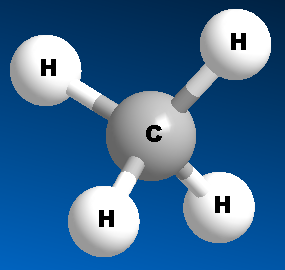

In [2]:
from IPython.display import Image
Image(filename="assets/ch4_mol.png", width=150)

分子对应的 [输入卡](CH4.gjf)、[输出文件](CH4.out) 与 [fchk 文件](CH4.fchk) 在链接中可供下载。

In [26]:
with open("CH4.out", "r") as f:
    while "and normal coordinates" not in f.readline(): continue
    for _ in range(15): print(f.readline()[:-1])

                     1                      2                      3
                     A                      A                      A
 Frequencies --  1675.7695              1675.7695              1675.7695
 Red. masses --     1.1714                 1.1714                 1.1714
 Frc consts  --     1.9382                 1.9382                 1.9382
 IR Inten    --     6.6431                 6.6431                 6.6431
 Raman Activ --     3.8439                 3.8439                 3.8439
 Depolar (P) --     0.7500                 0.7500                 0.7500
 Depolar (U) --     0.8571                 0.8571                 0.8571
  Atom  AN      X      Y      Z        X      Y      Z        X      Y      Z
     1   6     0.12   0.00   0.00     0.00   0.02   0.12     0.00   0.12  -0.02
     2   1    -0.60   0.00   0.00     0.00  -0.08   0.11     0.00  -0.60  -0.01
     3   1    -0.60   0.00   0.00     0.00   0.23  -0.49     0.00   0.01   0.29
     4   1    -0.12   0.28  -0.20

我们这份文档的目标是重复其中的红外光谱强度 `IR Inten` 一项，并依据这一项对红外光谱进行绘制。

## 简正坐标的导出

这里的代码将会给出归一化后的简正坐标 `q_normed`。这是 [上一篇频率分析文档](freq_1.ipynb) 的主要内容，这里简单作一个回顾。

In [3]:
from formchk_interface import FormchkInterface
import numpy as np
from functools import partial
import scipy

np.set_printoptions(5, linewidth=150, suppress=True)
np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])

In [4]:
# https://docs.scipy.org/doc/scipy/reference/constants.html
from scipy.constants import physical_constants

E_h = physical_constants["Hartree energy"][0]
a_0 = physical_constants["Bohr radius"][0]
N_A = physical_constants["Avogadro constant"][0]
c_0 = physical_constants["speed of light in vacuum"][0]
e_c = physical_constants["elementary charge"][0]
e_0 = physical_constants["electric constant"][0]
mu_0 = physical_constants["mag. constant"][0]

In [5]:
class FreqAnal:
    
    def __init__(self, fchk_path):
        self.fchk_path = fchk_path
        self.obj = fchk = FormchkInterface(fchk_path)
        self.mol_weight = fchk.key_to_value("Real atomic weights")
        self.natm = natm = self.mol_weight.size
        self.mol_coord = fchk.key_to_value("Current cartesian coordinates").reshape((natm, 3))
        self.mol_hess = fchk.hessian()
        self.mol_hess = (self.mol_hess + self.mol_hess.T) / 2
        self.mol_hess = self.mol_hess.reshape((natm, 3, natm, 3))
        self._theta = NotImplemented     # Force constant tensor
        self._proj_inv = NotImplemented  # Inverse space of translation and rotation of theta
        self._freq = NotImplemented      # Frequency in cm-1 unit
        self._q = NotImplemented         # Unnormalized normal coordinate
        self._qnorm = NotImplemented     # Normalized normal coordinate
        
    @property
    def theta(self):
        if self._theta is NotImplemented:
            natm, mol_hess, mol_weight = self.natm, self.mol_hess, self.mol_weight
            self._theta = np.einsum("AtBs, A, B -> AtBs", mol_hess, 1 / np.sqrt(mol_weight), 1 / np.sqrt(mol_weight)).reshape(3 * natm, 3 * natm)
        return self._theta
    
    @property
    def center_coord(self):
        return (self.mol_coord * self.mol_weight[:, None]).sum(axis=0) / self.mol_weight.sum()
    
    @property
    def centered_coord(self):
        return self.mol_coord - self.center_coord
    
    @property
    def rot_eig(self):
        natm, centered_coord, mol_weight = self.natm, self.centered_coord, self.mol_weight
        rot_tmp = np.zeros((natm, 3, 3))
        rot_tmp[:, 0, 0] = centered_coord[:, 1]**2 + centered_coord[:, 2]**2
        rot_tmp[:, 1, 1] = centered_coord[:, 2]**2 + centered_coord[:, 0]**2
        rot_tmp[:, 2, 2] = centered_coord[:, 0]**2 + centered_coord[:, 1]**2
        rot_tmp[:, 0, 1] = rot_tmp[:, 1, 0] = - centered_coord[:, 0] * centered_coord[:, 1]
        rot_tmp[:, 1, 2] = rot_tmp[:, 2, 1] = - centered_coord[:, 1] * centered_coord[:, 2]
        rot_tmp[:, 2, 0] = rot_tmp[:, 0, 2] = - centered_coord[:, 2] * centered_coord[:, 0]
        rot_tmp = (rot_tmp * mol_weight[:, None, None]).sum(axis=0)
        _, rot_eig = np.linalg.eigh(rot_tmp)
        return rot_eig
    
    @property
    def proj_scr(self):
        natm, centered_coord, rot_eig, mol_weight = self.natm, self.centered_coord, self.rot_eig, self.mol_weight
        rot_coord = np.einsum("At, ts, rw -> Asrw", centered_coord, rot_eig, rot_eig)
        proj_scr = np.zeros((natm, 3, 6))
        proj_scr[:, (0, 1, 2), (0, 1, 2)] = 1
        proj_scr[:, :, 3] = (rot_coord[:, 1, :, 2] - rot_coord[:, 2, :, 1])
        proj_scr[:, :, 4] = (rot_coord[:, 2, :, 0] - rot_coord[:, 0, :, 2])
        proj_scr[:, :, 5] = (rot_coord[:, 0, :, 1] - rot_coord[:, 1, :, 0])
        proj_scr *= np.sqrt(mol_weight)[:, None, None]
        proj_scr.shape = (-1, 6)
        proj_scr /= np.linalg.norm(proj_scr, axis=0)
        return proj_scr
    
    @property
    def proj_inv(self):
        if self._proj_inv is NotImplemented:
            natm, proj_scr, theta = self.natm, self.proj_scr, self.theta
            proj_inv = np.zeros((natm * 3, natm * 3))
            proj_inv[:, :6] = proj_scr
            x_col = 6 - 1
            for A_col in range(6, natm * 3):
                stat = True
                while stat:  # first xcol - 6 values in vector t should be zero
                    x_col += 1
                    x0 = np.zeros((natm * 3, ))
                    x0[x_col - 6] = 1
                    t = x0 - proj_inv[:, :A_col].T @ x0 @ proj_inv[:, :A_col].T
                    t /= np.linalg.norm(t)
                    stat = (np.linalg.norm(t[:x_col - 6]) > 1e-7)
                proj_inv[:, A_col] = t
            proj_inv = proj_inv[:, 6:]
            self._proj_inv = proj_inv
        return self._proj_inv
    
    def _get_freq_qdiag(self):
        natm, proj_inv, theta, mol_weight = self.natm, self.proj_inv, self.theta, self.mol_weight
        e, q = np.linalg.eigh(proj_inv.T @ theta @ proj_inv)
        freq = np.sqrt(np.abs(e * E_h * 1000 * N_A / a_0**2)) / (2 * np.pi * c_0 * 100) * ((e > 0) * 2 - 1)
        self._freq = freq
        q_unnormed = np.einsum("AtQ, A -> AtQ", (proj_inv @ q).reshape(natm, 3, (proj_inv @ q).shape[-1]), 1 / np.sqrt(mol_weight))
        q_unnormed = q_unnormed.reshape(-1, q_unnormed.shape[-1])
        q_normed = q_unnormed / np.linalg.norm(q_unnormed, axis=0)
        self._q = q_unnormed
        self._qnorm = q_normed
    
    @property
    def freq(self):
        if self._freq is NotImplemented:
            self._get_freq_qdiag()
        return self._freq
    
    @property
    def q(self):
        if self._q is NotImplemented:
            self._get_freq_qdiag()
        return self._q
    
    @property
    def qnorm(self):
        if self._qnorm is NotImplemented:
            self._get_freq_qdiag()
        return self._qnorm

In [6]:
fchk = FreqAnal("CH4.fchk")

In [7]:
fchk.freq

array([1675.76946, 1675.76946, 1675.76947, 1903.7231 , 1903.72311, 3525.8641 , 3786.57203, 3786.57206, 3786.57207])

In [8]:
FactIR = (e_c * N_A) * np.sqrt(1 / 10000000 * np.pi / 3)
FactIR

31.22307017202692

In [9]:
e_c

1.602176634e-19

In [38]:
dipderiv_mode = np.einsum("Ar, Aq -> qr", fchk.obj.dipolederiv(), fchk.q) * FactIR
dipderiv_mode

array([[ 2.57742, -0.     , -0.     ],
       [ 0.     ,  0.54676,  2.51876],
       [ 0.     ,  2.51876, -0.54676],
       [-0.     , -0.     ,  0.     ],
       [-0.     ,  0.     , -0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     , -0.01668,  0.68369],
       [ 0.68389, -0.     ,  0.     ],
       [ 0.     , -0.68369, -0.01668]])

In [20]:
natm = 5

In [27]:
fchk.qnorm.reshape(natm, 3, 3 * natm - 6)[:, :, 3:6].transpose((2, 0, 1))

array([[[-0.     , -0.     ,  0.     ],
        [ 0.5    , -0.     ,  0.     ],
        [-0.5    , -0.     ,  0.     ],
        [-0.     ,  0.28868,  0.40825],
        [ 0.     , -0.28868, -0.40825]],

       [[ 0.     , -0.     ,  0.     ],
        [-0.     , -0.5    ,  0.     ],
        [ 0.     , -0.16667,  0.4714 ],
        [-0.28868,  0.33333, -0.2357 ],
        [ 0.28868,  0.33333, -0.2357 ]],

       [[-0.     ,  0.     ,  0.     ],
        [ 0.     , -0.     , -0.5    ],
        [ 0.     ,  0.4714 ,  0.16667],
        [-0.40825, -0.2357 ,  0.16667],
        [ 0.40825, -0.2357 ,  0.16667]]])

In [22]:
fchk.freq

array([1675.76946, 1675.76946, 1675.76947, 1903.7231 , 1903.72311, 3525.8641 , 3786.57203, 3786.57206, 3786.57207])

In [ ]:
                     1                      2                      3
                     A                      A                      A
 Frequencies --  1675.7695              1675.7695              1675.7695
 Red. masses --     1.1714                 1.1714                 1.1714
 Frc consts  --     1.9382                 1.9382                 1.9382
 IR Inten    --     6.6431                 6.6431                 6.6431
 Raman Activ --     3.8439                 3.8439                 3.8439
 Depolar (P) --     0.7500                 0.7500                 0.7500
 Depolar (U) --     0.8571                 0.8571                 0.8571
  Atom  AN      X      Y      Z        X      Y      Z        X      Y      Z
     1   6     0.12   0.00   0.00     0.00   0.02   0.12     0.00   0.12  -0.02
     2   1    -0.60   0.00   0.00     0.00  -0.08   0.11     0.00  -0.60  -0.01
     3   1    -0.60   0.00   0.00     0.00   0.23  -0.49     0.00   0.01   0.29
     4   1    -0.12   0.28  -0.20    -0.16  -0.17  -0.53     0.30  -0.43  -0.05
     5   1    -0.12  -0.28   0.20     0.16  -0.17  -0.53    -0.30  -0.43  -0.05

In [33]:
ir_intensities = (dipderiv_mode ** 2).sum(axis=1)
ir_intensities

array([6.64311, 6.64311, 6.64311, 0.     , 0.     , 0.     , 0.46771, 0.46771, 0.46771])